# Explore here

IMPORTS

In [105]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import lazypredict.Supervised
from lazypredict.Supervised import LazyRegressor
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV


Loading the dataset and general revision 

In [50]:
df = pd.read_csv('/workspaces/JMP1STLinear-Regression-Project-Tutorial/data/raw/medical_insurance_cost.csv')
pd.set_option('display.max_columns', None)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86


Declaring a new index for the data set

In [51]:
#First let's reset the already defined index (0, 1, 2...)
df.reset_index(drop=True, inplace=True)

#Now let's define the new index
df['customer_id'] = df.index

#Now let's set the new index
df.set_index('customer_id', inplace=True)

#Now just to make sure that the new index is customer_id we tell pandas what is going on more explicity
df.index.name = 'customer_id'

df.head()

,age,sex,bmi,children,smoker,region,charges
customer_id,,,,,,,
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86


EDA ANALYSIS

In [52]:
#Let's start the anlysis by checking the dimiensions of the dataset in question (shape)

df.shape

(1338, 7)

We can see that we are working with 1338 rows spread throug 7 variables.

Let's now take a look at the info of each variable

In [53]:
#Checking out the variables info

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


As the info shows, the values of the 7 variables are distributed in two floats (``bmi`` and ``charges``), two integers (``age`` and ``children``) and three objects (``sex``, ``smoker`` and ``region``). 

Now let's search for unique values in those 7 variables to start planning the encoding and to check for constant values

In [54]:
#Counting the unique values

unique_values = df.nunique()
unique_values

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [55]:
#Checking waht those unique values are (This returns an array of uniques values per column). This will come handy by the time we start the encoding process
#And also to decide if the column needs to be dropped or if it is meaningful

#For each col(i) in columns(range) check for unique values
for col in df.columns:
    print(f"\n{col} - Unique values:")
    print(df[col].unique())


age - Unique values:
[19 18 28 33 32 31 46 37 60 25 62 23 56 27 52 30 34 59 63 55 22 26 35 24
 41 38 36 21 48 40 58 53 43 64 20 61 44 57 29 45 54 49 47 51 42 50 39]

sex - Unique values:
['female' 'male']

bmi - Unique values:
[27.9   33.77  33.    22.705 28.88  25.74  33.44  27.74  29.83  25.84
 26.22  26.29  34.4   39.82  42.13  24.6   30.78  23.845 40.3   35.3
 36.005 32.4   34.1   31.92  28.025 27.72  23.085 32.775 17.385 36.3
 35.6   26.315 28.6   28.31  36.4   20.425 32.965 20.8   36.67  39.9
 26.6   36.63  21.78  30.8   37.05  37.3   38.665 34.77  24.53  35.2
 35.625 33.63  28.    34.43  28.69  36.955 31.825 31.68  22.88  37.335
 27.36  33.66  24.7   25.935 22.42  28.9   39.1   36.19  23.98  24.75
 28.5   28.1   32.01  27.4   34.01  29.59  35.53  39.805 26.885 38.285
 37.62  41.23  34.8   22.895 31.16  27.2   26.98  39.49  24.795 31.3
 38.28  19.95  19.3   31.6   25.46  30.115 29.92  27.5   28.4   30.875
 27.94  35.09  29.7   35.72  32.205 28.595 49.06  27.17  23.37  37.1
 23.7

The column ``charges`` as is the objective column will be drop off later on the project, for now, we can extract some useful information as we can see that all the columns are meaningful. We can continue with the analysis

Let's now check for duplicated values in the df 

In [56]:
#Checking for duplicated values 

print(F"Amount of duplicated values is: {df.duplicated().sum()}")

#Let's inspect where and what is that duplicated value
df[df.duplicated(keep=False)]

Amount of duplicated values is: 1


,age,sex,bmi,children,smoker,region,charges
customer_id,,,,,,,
195,19,male,30.59,0,no,northwest,1639.56
581,19,male,30.59,0,no,northwest,1639.56


After careful consideration I have come to conclude that since ``charges`` is a float with high cardinality and the duplicated rows still matched exactly, it's very likely this is a duplicate entry error, therefore, I have decided to drop the second instance of the matching values (customer_id=581) to not influence the model and reduce the amount of noise.

In [57]:
#Droping the duplicated row by its index

df.drop(index=581, inplace=True)

print(F"Amount of duplicated values after droping index=581 is: {df.duplicated().sum()}")

Amount of duplicated values after droping index=581 is: 0


Now that our data is free of duplicates and we are gathering more information let's search for missing values

In [58]:
#Checking for missing values

df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

It appears that we have no null values in our df, based on this we can continue with the following EDA point.


Descriptive Statistics (for numerical variables)

In [59]:
#Checking the descriptive statistics of numerical columns

df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.00,39.22,14.04,18.00,27.00,39.00,51.00,64.00
bmi,1337.00,30.66,6.10,15.96,26.29,30.40,34.70,53.13
children,1337.00,1.10,1.21,0.00,0.00,1.00,2.00,5.00
charges,1337.00,13279.12,12110.36,1121.87,4746.34,9386.16,16657.72,63770.43


Brief Statistics analysis: 

We have records with ages ranging from 18 to 64 years and a mean age of 39.2, indicating a primarily adult population with a fairly symmetric age distribution. BMI values range from 15.96 to 53.13 with an average of 30.7, suggesting most individuals are overweight or obese, and some potential outliers exist on both ends. The number of children per individual varies between 0 and 5, averaging about 1.1, showing moderate variability. Insurance charges span a wide range from roughly $1,122 to over $63,770, with a mean of $13,279 and a median of $9,386. Overall, the data distributions appear reasonable.

Plotting for better understanding

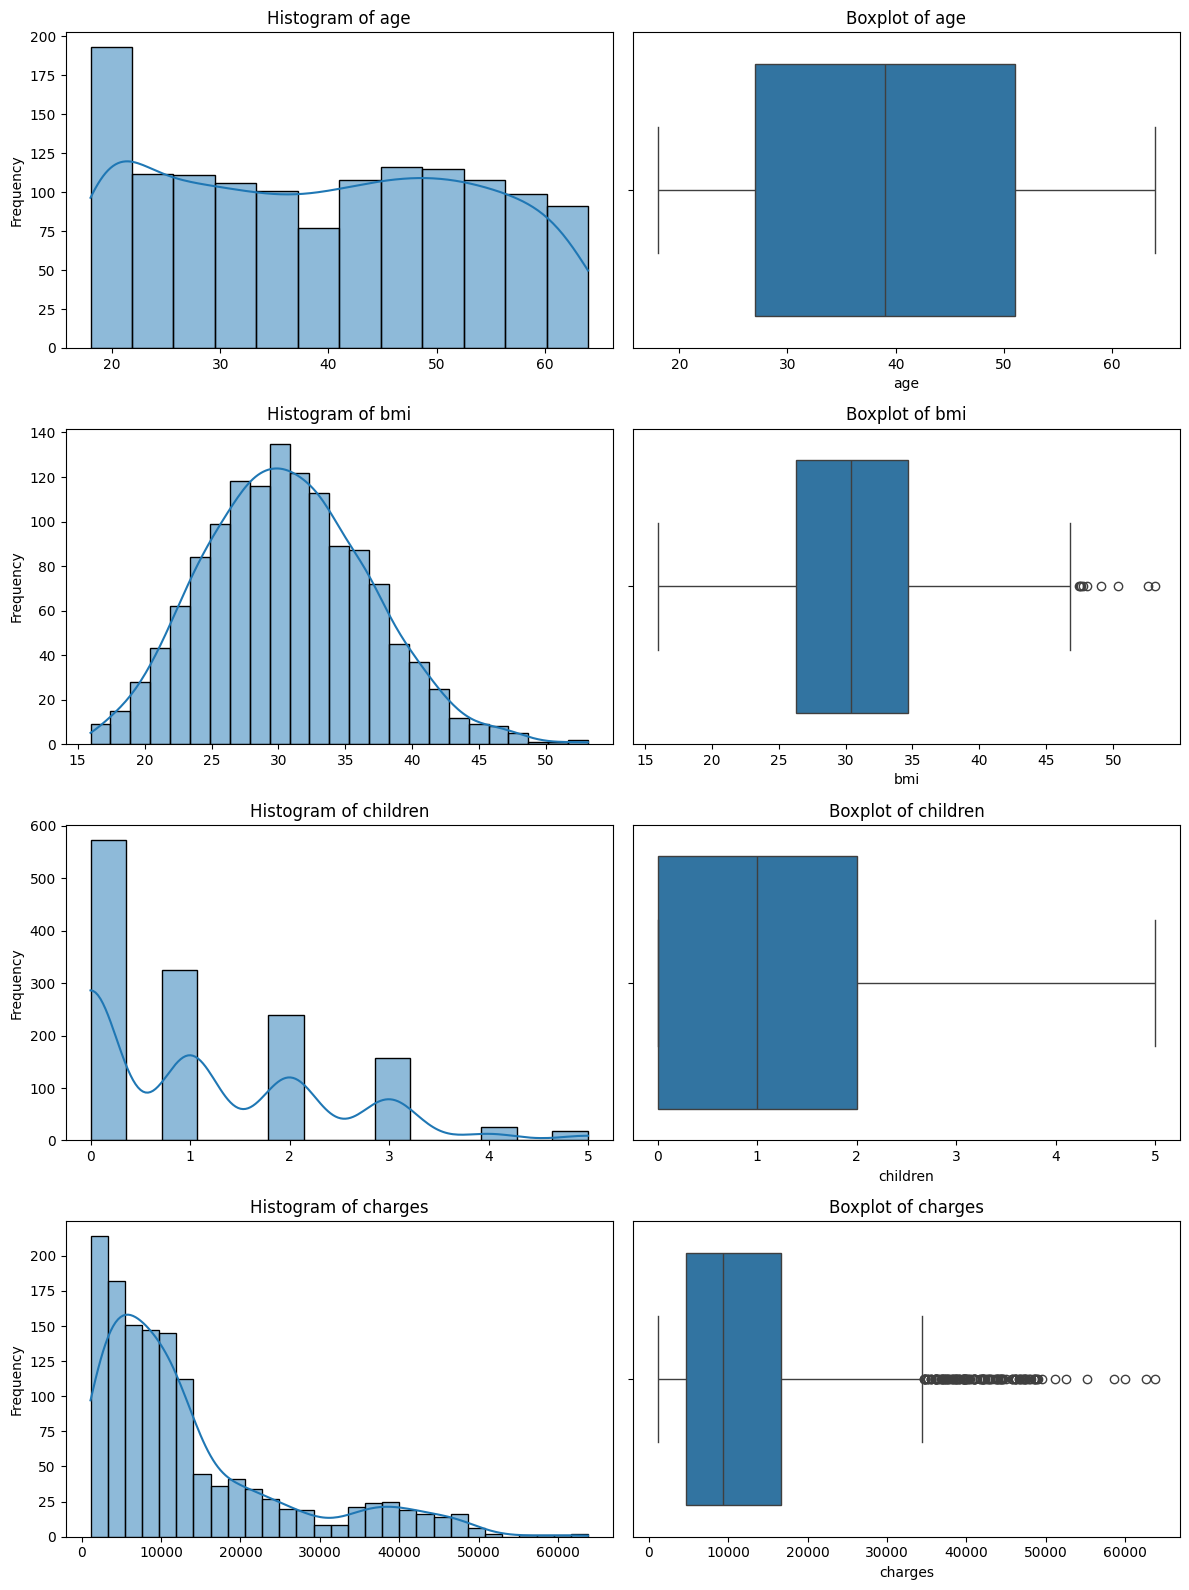

In [60]:
numerical_cols = ['age', 'bmi', 'children', 'charges']

fig, axes = plt.subplots(len(numerical_cols), 2, figsize=(12, 16))

for i, col in enumerate(numerical_cols):
    # Histogram in the left column
    sns.histplot(df[col], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {col}')
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel('Frequency')
    
    # Boxplot in the right column
    sns.boxplot(x=df[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col}')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('')

plt.tight_layout()
plt.show()


Now let's check the data distribution of categorical variables

In [61]:
#Counting cat. variables values count

print(F"% for variable: \n{df['sex'].value_counts(normalize=True)}\nValue counts for variable: \n{df['sex'].value_counts()}\n")

print(F"% for variable: \n{df['smoker'].value_counts(normalize=True)}\nValue counts for variable: \n{df['smoker'].value_counts()}\n")

print(F"% for variable: \n{df['region'].value_counts(normalize=True)}\nValue counts for variable: \n{df['region'].value_counts()}")


% for variable: 
sex
male     0.50
female   0.50
Name: proportion, dtype: float64
Value counts for variable: 
sex
male      675
female    662
Name: count, dtype: int64

% for variable: 
smoker
no    0.80
yes   0.20
Name: proportion, dtype: float64
Value counts for variable: 
smoker
no     1063
yes     274
Name: count, dtype: int64

% for variable: 
region
southeast   0.27
southwest   0.24
northwest   0.24
northeast   0.24
Name: proportion, dtype: float64
Value counts for variable: 
region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64


Brief data distribution analysis: 

The categorical variables show that the dataset has a balanced gender distribution with 675 males and 662 females. Smoking status is imbalanced, with approximately 80% non-smokers (1,063) and 20% smokers (274), which may impact modeling outcomes. The four regions—southeast, southwest, northwest, and northeast—are evenly represented, each containing around 324 to 364 observations, indicating no regional sampling bias.

Plotting for better understanding 

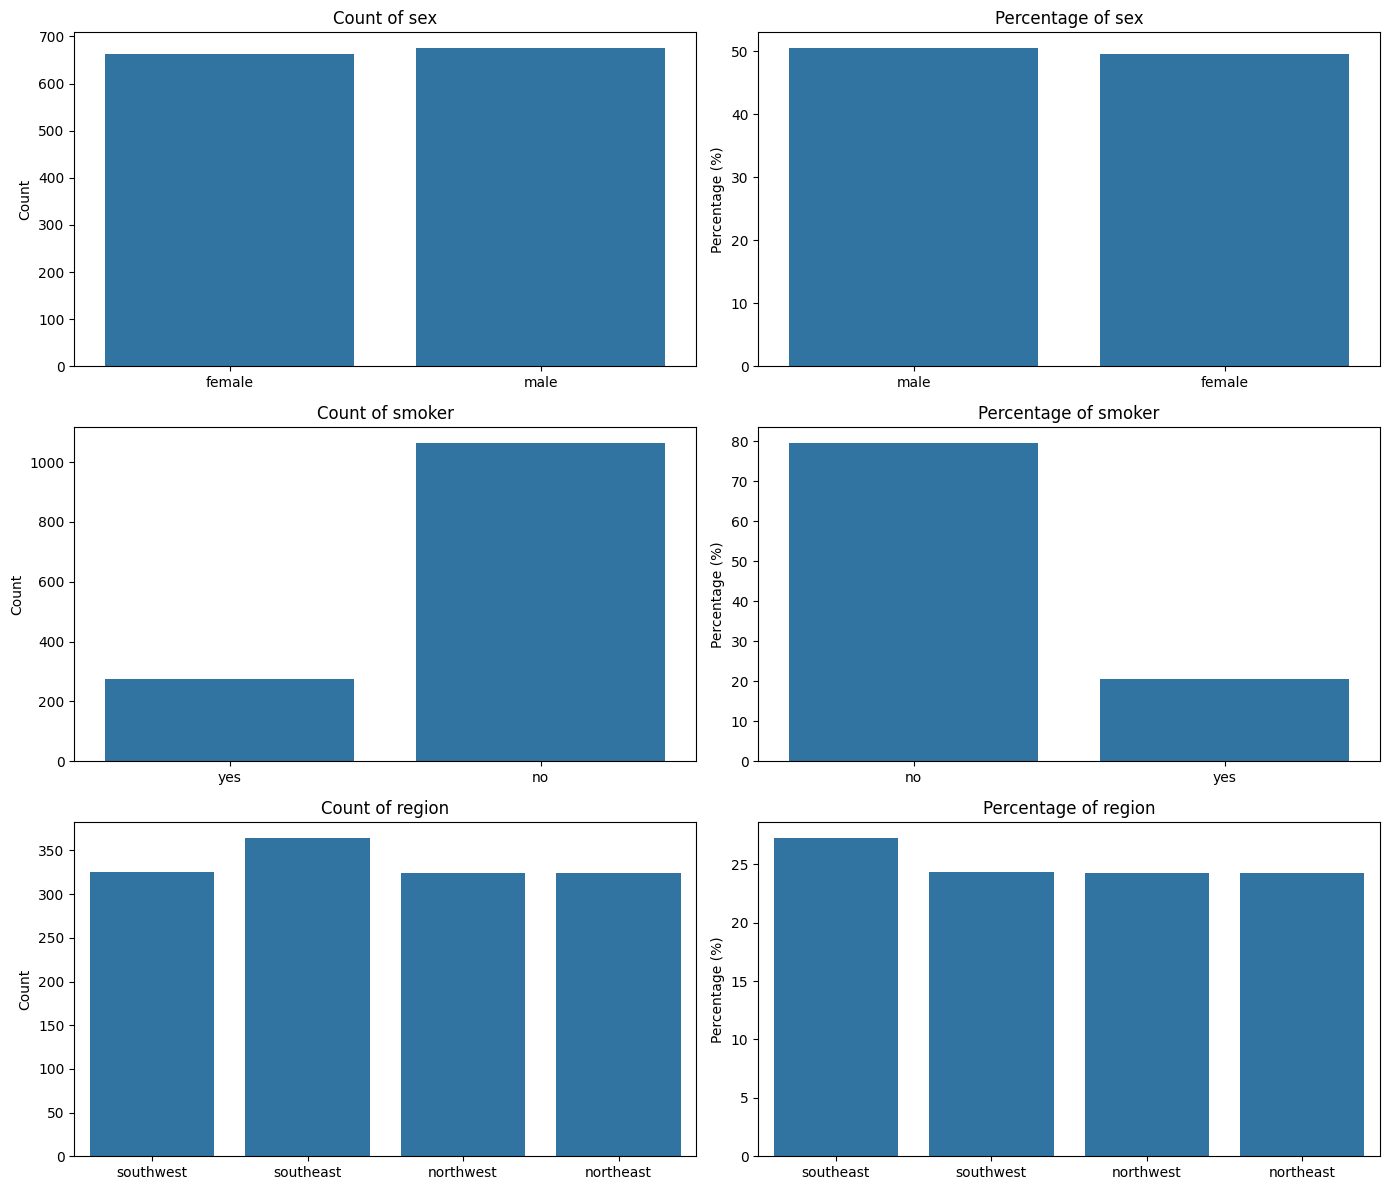

In [62]:
categorical_cols = ['sex', 'smoker', 'region']

fig, axes = plt.subplots(len(categorical_cols), 2, figsize=(14, 12))

for i, col in enumerate(categorical_cols):
    # Count plot (absolute counts)
    sns.countplot(x=col, data=df, ax=axes[i, 0])
    axes[i, 0].set_title(f'Count of {col}')
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel('Count')
    
    # Percentage plot
    value_counts = df[col].value_counts(normalize=True) * 100
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i, 1])
    axes[i, 1].set_title(f'Percentage of {col}')
    axes[i, 1].set_ylabel('Percentage (%)')
    axes[i, 1].set_xlabel('')

plt.tight_layout()
plt.show()


Now let's analyze the correlations 

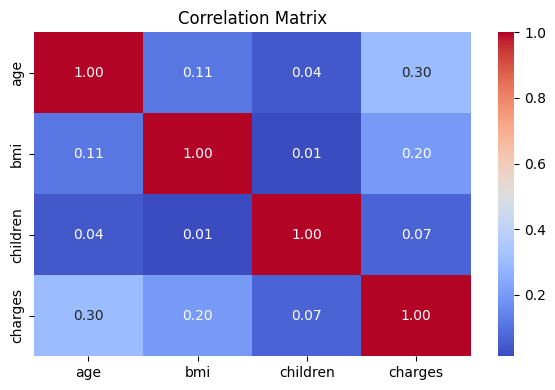

In [63]:
#Checking for correlations 

corr = df[['age', 'bmi', 'children', 'charges']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()

Overall, age and BMI are the most influential numeric predictors of charges in the df

As we saw earlier in the boxplots, two variables show multiple outliers. For `charges`, we'll apply a log transformation to reduce skew and preserve the natural variation important for prediction. For `bmi`, we'll cap the outliers to limit their influence while keeping all records in the dataset.


In [64]:
#Caping bmi outliers by using IQR 

#First we calculate the IQR 
Q1 = df['bmi'].quantile(0.25)
Q3 = df['bmi'].quantile(0.75)

#Then we can say
IQR = Q3 - Q1

#Declaring boundaries for cap
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#Then we cap the outliers
df['bmi'] = df['bmi'].clip(lower=lower_bound, upper=upper_bound)

df.head()

,age,sex,bmi,children,smoker,region,charges
customer_id,,,,,,,
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86


Now let's log transform ``charges`` using Numpy, this reduces the impact of extreme high values and makes the distribution more normal

In [65]:
df['log_charges'] = np.log(df['charges'])
df.head()

,age,sex,bmi,children,smoker,region,charges,log_charges
customer_id,,,,,,,,
0,19,female,27.90,0,yes,southwest,16884.92,9.73
1,18,male,33.77,1,no,southeast,1725.55,7.45
2,28,male,33.00,3,no,southeast,4449.46,8.40
3,33,male,22.70,0,no,northwest,21984.47,10.00
4,32,male,28.88,0,no,northwest,3866.86,8.26


Plotting to check the new outliers after caping and log transforming ``charges``

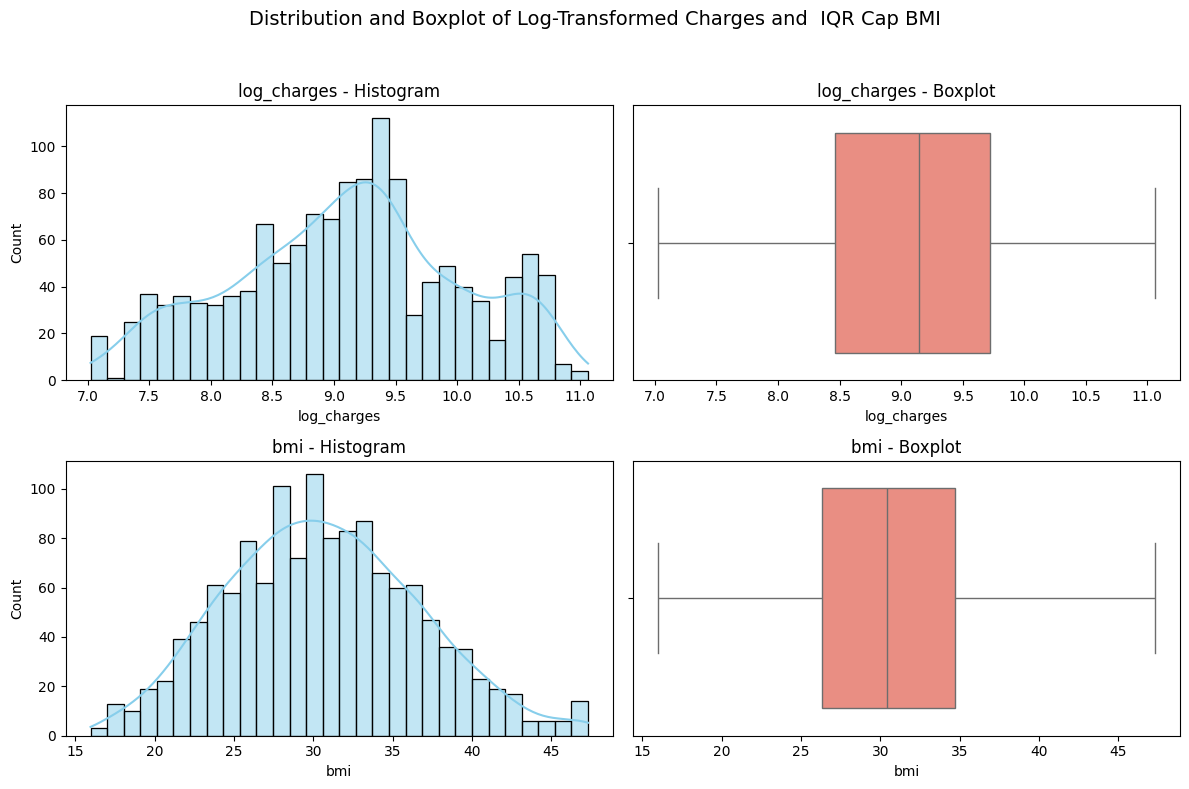

In [66]:
#Variables to plot
columns_to_plot = ['log_charges', 'bmi']

#Setup 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Distribution and Boxplot of Log-Transformed Charges and  IQR Cap BMI', fontsize=14)

for i, col in enumerate(columns_to_plot):
    #Histogram
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f'{col} - Histogram')
    axes[i, 0].set_xlabel(col)

    #Boxplot
    sns.boxplot(x=df[col], ax=axes[i, 1], color='salmon')
    axes[i, 1].set_title(f'{col} - Boxplot')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


The log transformation of `charges` makes the data more balanced and less stretched out, which helps the model learn better. The `bmi` data still has some high values that stand out, so capping those will reduce their effect without losing any data.

Also, as we already have ``log_charges`` as a variable let's drop the ``charges`` to prevent redundancy.

In [67]:
df.drop(columns=['charges'], inplace=True)
df.head()

,age,sex,bmi,children,smoker,region,log_charges
customer_id,,,,,,,
0,19,female,27.90,0,yes,southwest,9.73
1,18,male,33.77,1,no,southeast,7.45
2,28,male,33.00,3,no,southeast,8.40
3,33,male,22.70,0,no,northwest,10.00
4,32,male,28.88,0,no,northwest,8.26


For organization purposes let's save a new df (cleaned_df)

In [68]:
cleaned_df = df.copy()
cleaned_df.to_csv('cleaned_df.csv', index=True)

Now that we have a clean set of data the encoding over the some categorical and numerical variables will be next

We will be using two forms of 'encoding' for sets of variables, let's start with the categorical ones 

In [69]:
#One hot encoding for categorical variables

#Using the "get._dummies trap with the drop_first=true as it deletes one to prevent redundancy as we clearly now that if is not (false) in each other region then is on region_northeast "
cleaned_df = pd.get_dummies(cleaned_df, columns=['sex', 'smoker', 'region'], drop_first=True)

cleaned_df.head()

,age,bmi,children,log_charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
customer_id,,,,,,,,,
0,19,27.90,0,9.73,False,True,False,False,True
1,18,33.77,1,7.45,True,False,False,True,False
2,28,33.00,3,8.40,True,False,False,True,False
3,33,22.70,0,10.00,True,False,True,False,False
4,32,28.88,0,8.26,True,False,True,False,False


As we can see now we have a dataframe that contains numeric (int and floats) and boolean values(True and False) and the most practical encoding method that I have found for this scenario is to use pd.to_numeric method from Pandas and convert the whole dataframe to numeric values mantining integers and floats intact.

In [70]:
#Applying the method pd.to_numeric to transform the whole df to numeric values
cleaned_df = cleaned_df.apply(pd.to_numeric)

#Declaring that the cleand_df is the int version of bool values in the df 
bool_cols = ['sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']
cleaned_df[bool_cols] = cleaned_df[bool_cols].astype(int)

cleaned_df.head()

,age,bmi,children,log_charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
customer_id,,,,,,,,,
0,19,27.90,0,9.73,0,1,0,0,1
1,18,33.77,1,7.45,1,0,0,1,0
2,28,33.00,3,8.40,1,0,0,1,0
3,33,22.70,0,10.00,1,0,1,0,0
4,32,28.88,0,8.26,1,0,1,0,0


Let's clearly visualize this principle of numerical encoding and map the values for future references

In [71]:
#To visualize 'encoded' values categorical values

#Mapping to reference values with numbers
mapping = {
    'sex_male': {0: 'female', 1: 'male'},
    'smoker_yes': {0: 'non-smoker', 1: 'smoker'},
    'region_northwest': {0: 'not northwest', 1: 'northwest'},
    'region_southeast': {0: 'not southeast', 1: 'southeast'},
    'region_southwest': {0: 'not southwest', 1: 'southwest'}
}

#Looping through each item in mapping and printing the 'col' name and then looping to get bot keys values 
for col, map_dict in mapping.items():
    print(f"{col}:")
    for k, v in map_dict.items():
        print(f"  {k} = {v}")
    print()
print("The rest of the variables are self-explicatory")

sex_male:
  0 = female
  1 = male

smoker_yes:
  0 = non-smoker
  1 = smoker

region_northwest:
  0 = not northwest
  1 = northwest

region_southeast:
  0 = not southeast
  1 = southeast

region_southwest:
  0 = not southwest
  1 = southwest

The rest of the variables are self-explicatory


Now that we have the final dataframe in the desired form let's save it and continue to split the data 

In [72]:
final_df = cleaned_df.copy()

final_df.to_csv('final_df.csv', index=False)

final_df.head()

,age,bmi,children,log_charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
customer_id,,,,,,,,,
0,19,27.90,0,9.73,0,1,0,0,1
1,18,33.77,1,7.45,1,0,0,1,0
2,28,33.00,3,8.40,1,0,0,1,0
3,33,22.70,0,10.00,1,0,1,0,0
4,32,28.88,0,8.26,1,0,1,0,0


DATA PARTITIONING

In [73]:
#We drop the target variable as this is what we are trying to predict
X = final_df.drop(['log_charges'],axis=1)

#Then we pass the predictions to the y variable becasue this is the variable the model will learn to predict
y = final_df['log_charges']

#Then instancing the train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's take a look on the shapes of each X (X_train and X_test)

In [74]:
print(F"The X_train shape has {X_train.shape[0]} rows and {X_train.shape[1]} variables that corresponds to the 80% of the data")
print(F"The X_test shape has {X_test.shape[0]} rows and {X_test.shape[1]} variables that corresponds to the 20% of the data")

The X_train shape has 1069 rows and 8 variables that corresponds to the 80% of the data
The X_test shape has 268 rows and 8 variables that corresponds to the 20% of the data


Now that we have splited our data and confirmed is properly distributed let's continue with the analysis by detecting influential observations

In [75]:
#Adds a constant column
X_train_const = sm.add_constant(X_train)

#Fits the OLS regression model
model = sm.OLS(y_train, X_train_const).fit()

#stats
cooks_distance = model.get_influence().cooks_distance

Plot for visual representation of cooks distance

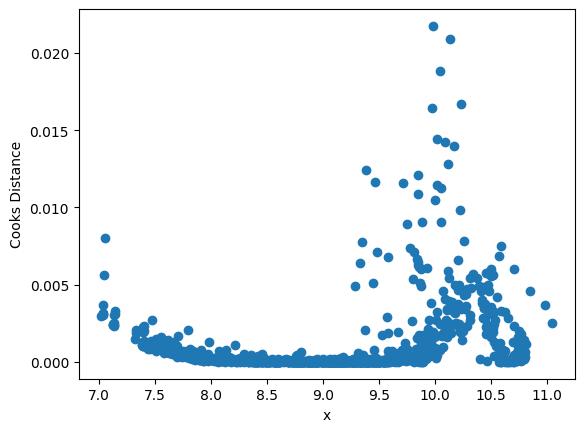

In [76]:
#Scatter plot for cooks distance
plt.scatter(y_train, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

Cook’s Distance plot shows that most observations have very low influence on the model. However, let's set the cooks distance threshold and analyze again the plot and subsequently the columns to be droped due to the influence the could cause on the model.

In [77]:
#Setting the threshold of cooks distance 
cut_point = 4/len(X_train)

In [78]:
#Showing where the cooks distances calculates potential influence observations
np.where(cooks_distance[0]>cut_point)[0]

array([   2,    8,   53,   81,   82,   91,   96,  111,  125,  127,  133,
        154,  163,  170,  177,  178,  188,  190,  195,  197,  204,  205,
        218,  248,  287,  293,  333,  334,  343,  344,  381,  402,  404,
        406,  409,  411,  425,  436,  492,  524,  527,  568,  578,  580,
        597,  599,  654,  655,  661,  721,  726,  731,  736,  740,  752,
        775,  781,  796,  798,  799,  826,  827,  835,  844,  864,  883,
        901,  912,  933,  943,  948,  980, 1002, 1012, 1015, 1024, 1041,
       1052])

Now that we have the instances where cooks distance is greater than its threshold, we can drop those instances to prevent disproportion from affecting the model

In [79]:
#Where the cook distance is greater than its threshold 
idx_influential_points = np.where(cooks_distance[0]>cut_point)[0]

print(f'Percentage of influential points to drop: {len(idx_influential_points)/len(df)*100}%')

Percentage of influential points to drop: 5.833956619296933%


After performing cooks distance we have determined to drop 5.83% of the data, let's do it following the class approach as I find it safer 

In [80]:
#First we declare a new X_train and then we select the rows that are not influential 
X_train1 = X_train.loc[~X_train.index.isin(X_train.index[idx_influential_points]),:] 
y_train1 = y_train.loc[~X_train.index.isin(X_train.index[idx_influential_points])]

In [81]:
print(F"After cleaning 5.83% out the data (influential points) X_train1 shape has {X_train1.shape[0]} rows and {X_train1.shape[1]} variables that corespond with the {y_train1.shape[0]} rows of y_train1")

After cleaning 5.83% out the data (influential points) X_train1 shape has 991 rows and 8 variables that corespond with the 991 rows of y_train1


Now that we have a clearer train and test data we can continue with selecting the categories 

In [82]:
#First we instance the regressor 
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train, y_train)

#Then we create an importances dataframe
dict_data = {'Feature':X_train.columns, 'Importance':xgb_model.feature_importances_*100}
df_imp = pd.DataFrame(dict_data)

#Sorting by importance
df_imp.sort_values(by='Importance', ascending=False, inplace=True)

In [83]:
#Variables with importance >=1
df_imp[df_imp['Importance']>=1]

,Feature,Importance
4,smoker_yes,84.53
0,age,6.38
2,children,2.71
1,bmi,1.54
7,region_southwest,1.32
5,region_northwest,1.24
3,sex_male,1.19
6,region_southeast,1.10


Conclusion on Feature Importance:

The variable smoker_yes overwhelmingly dominates the model’s predictive power, contributing about 84.5% of the total importance. This indicates that smoking status is by far the most influential factor for the target outcome.

Other features like age (6.4%) and children (2.7%) have moderate importance but are much less impactful compared to smoking. The remaining features—bmi, different regions, and sex_male—each contribute around 1–1.5%, indicating they have relatively minor influence individually.

Overall, smoking status is the key driver in this model, with age and children having secondary roles, while other variables play smaller roles.

In [84]:
#Droping the non relevant characteristics
X_train1 = X_train1.drop(df_imp[df_imp['Importance'] < 1]['Feature'], axis=1)
X_test = X_test.drop(df_imp[df_imp['Importance'] < 1]['Feature'], axis=1)

After trying to drop columns with an Importance <1 I have come to conclude that there are no values that fall into that range 

Let's proceed with the VIF (Variance Inflation factor) to determine if and where the correlations are stronger potentially influencing our model

In [85]:
vif = pd.Series([variance_inflation_factor(X_train1.corr().values, i) for i in range(X_train1.corr().shape[1])], index=X_train1.columns)
vif

age                1.16
bmi                1.62
children           1.02
sex_male           1.04
smoker_yes         1.09
region_northwest   4.59
region_southeast   5.70
region_southwest   4.71
dtype: float64

The region variables (northwest, southeast, southwest) have the highest VIFs (around 4.5–5.7), indicating some correlation among these regional variables (which makes sense because they are mutually exclusive categories). This correlations, despite of not being that large could be harm the model performance so let's investigate them further to decide how to handle those

Ploting for better understanding 

<Axes: >

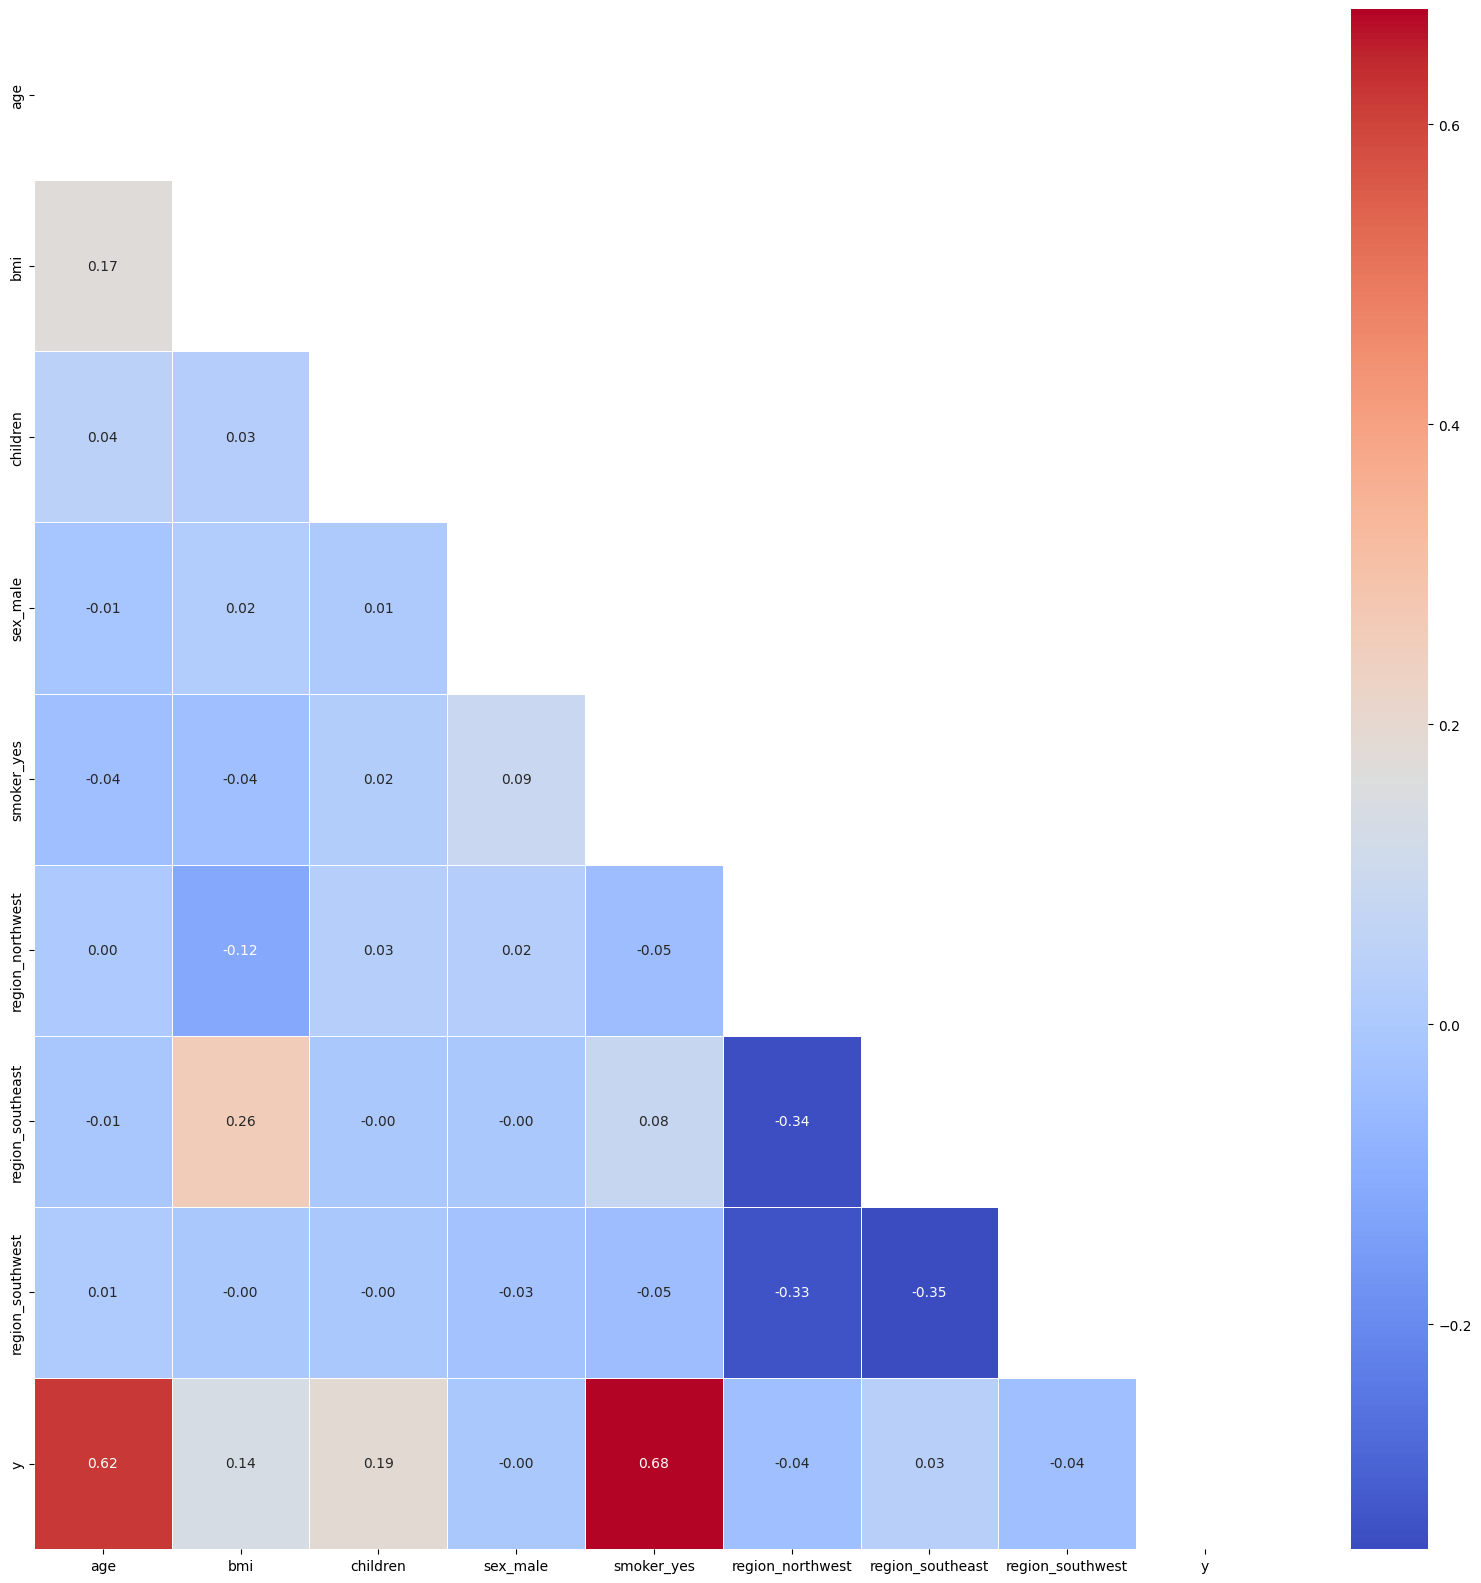

In [86]:
X_corr = X_train1.copy()
X_corr['y'] = y_train1
corr = X_corr.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20,20))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

The correlation map shows low to moderate relationships among the predictors, indicating minimal multicollinearity. To further reduce redundancy, the regional variables will be  merged into a single binary region variable ``region``, where 1 represents northern location and 0 represents southern ones. This transformation simplified the feature set and reduced multicollinearity, as confirmed by the updated VIF values, all of which are close to 1.

The decision to merged them lies on the relevance of the information inside them, how they behave. Despite of losing some geographicall precission the model will keep region (geographicall factor) and we are not losing relevant information, just transforming it. The model will be more precise due to the low correlation between the new region variable and the obj variable

In [87]:
# 1. Copy the full X
X_cleaned = X.copy()

# 2. Create 'region' binary column
X_cleaned['region'] = np.where(X_cleaned['region_northwest'] == 1, 1, 0)

# 3. Drop the one-hot region columns
X_cleaned.drop(['region_northwest', 'region_southeast', 'region_southwest'], axis=1, inplace=True)

# 4. Now split BOTH features and target
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.2, random_state=42)

In [88]:
#Checking if region was added as a new variable and checking its values
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1069 entries, 1114 to 1127
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         1069 non-null   int64  
 1   bmi         1069 non-null   float64
 2   children    1069 non-null   int64  
 3   sex_male    1069 non-null   int64  
 4   smoker_yes  1069 non-null   int64  
 5   region      1069 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 58.5 KB


In [89]:
#Checking if region was added an its distribution
X_train['region'].value_counts()

region
0    805
1    264
Name: count, dtype: int64

In [90]:
#Checking if region was added as a new variable and checking its values
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268 entries, 900 to 1285
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         268 non-null    int64  
 1   bmi         268 non-null    float64
 2   children    268 non-null    int64  
 3   sex_male    268 non-null    int64  
 4   smoker_yes  268 non-null    int64  
 5   region      268 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 14.7 KB


Now that we have guarantees that our new binary column ``region`` was added we can check how the VIF behaves after the modification

In [91]:
#Checking the new VIF1 
vif1 = pd.Series([variance_inflation_factor(X_train.corr().values, i) for i in range(X_train.corr().shape[1])], index=X_train.columns)
vif1

age          1.09
bmi          1.13
children     1.02
sex_male     1.04
smoker_yes   1.05
region       1.07
dtype: float64

Let's now take a more visual look at this improvement.

<Axes: >

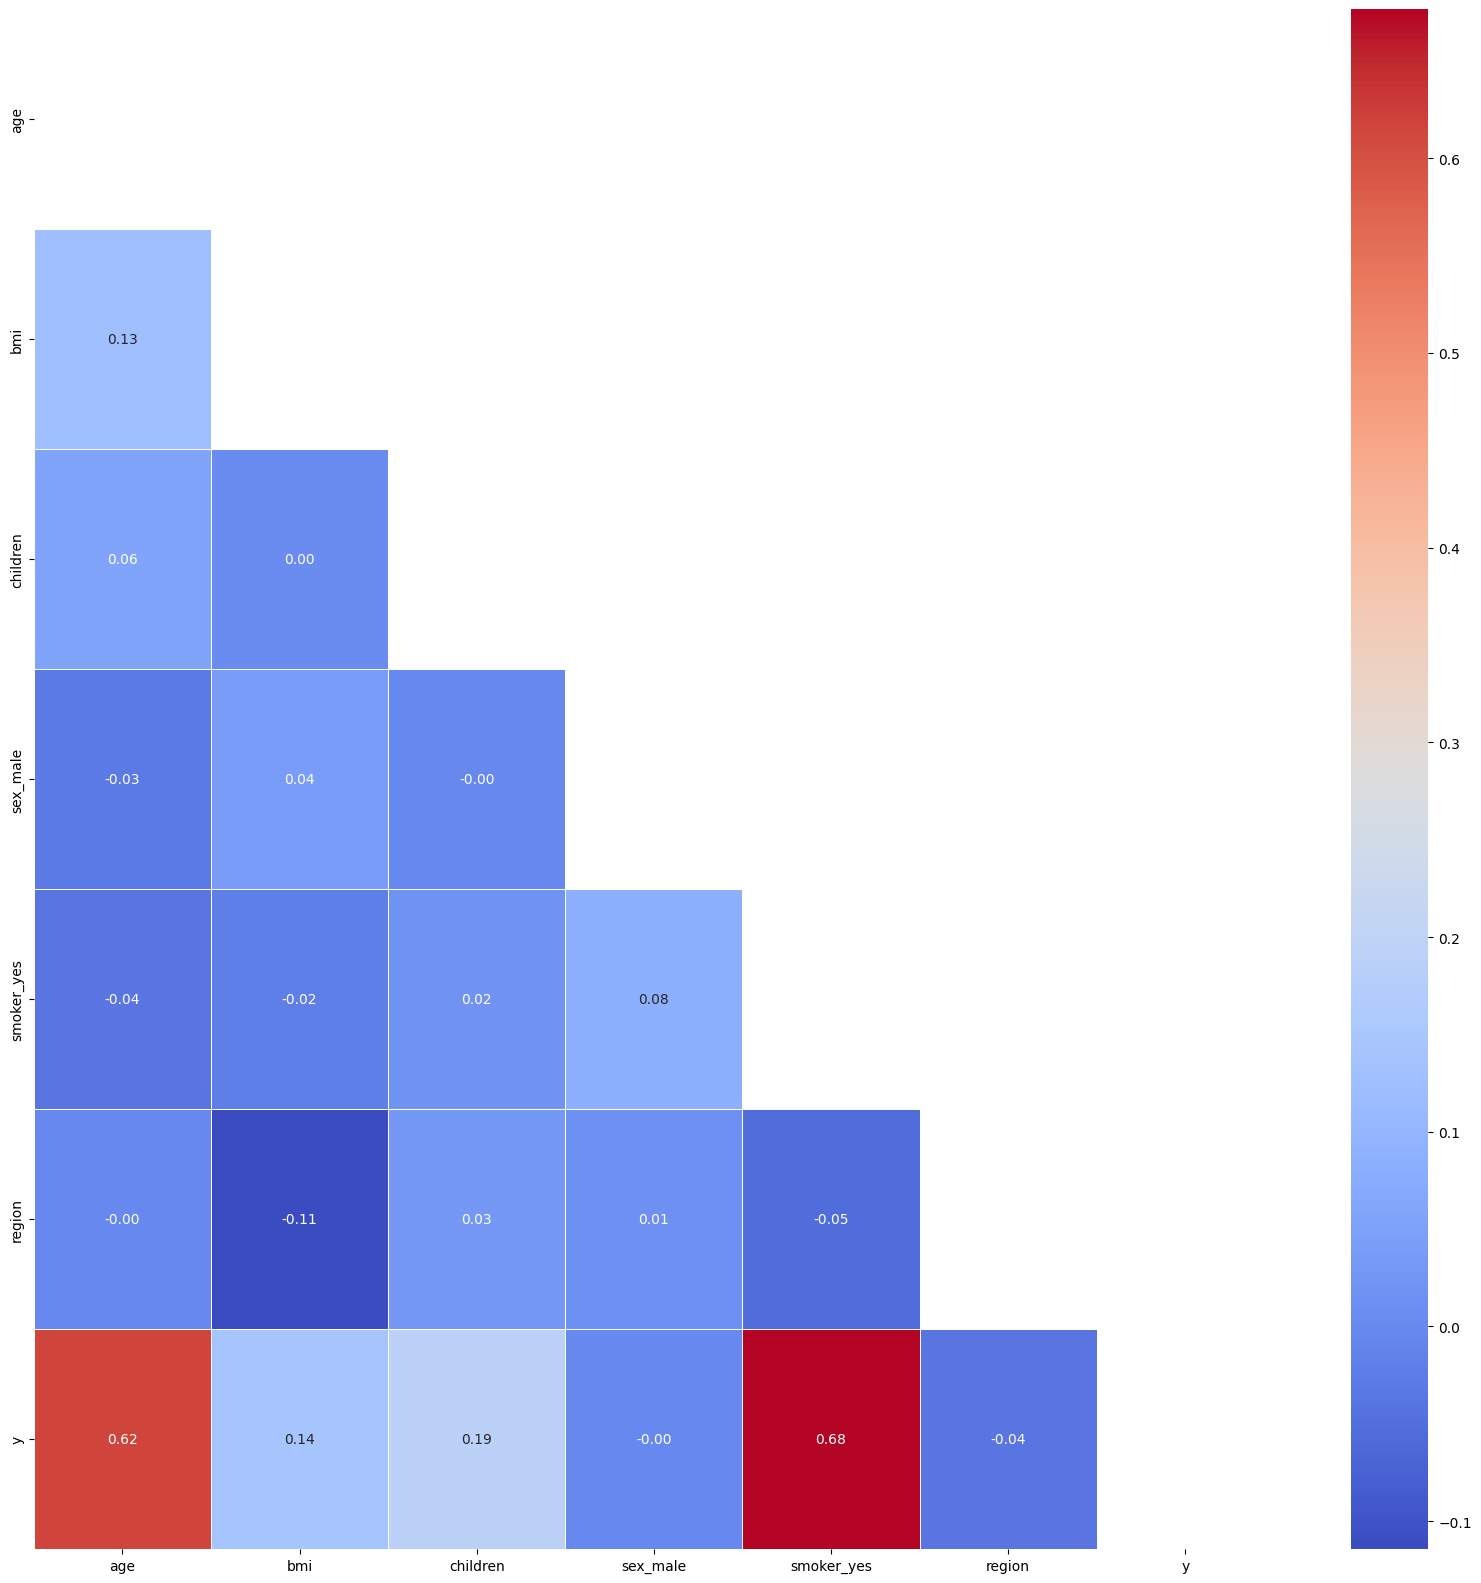

In [92]:
X_corr = X_train.copy()
X_corr['y'] = y_train1
corr = X_corr.corr()


mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20,20))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

We can clearly see that after merging the regional dummy variables into a single binary variable (region), the Variance Inflation Factor (VIF) values have been considerably reduced. All predictors now show VIFs close to 1, indicating minimal multicollinearity and a more stable feature set.

Let's continue with the order of methods and scale the characteristics 

In [93]:
#Initialize the scaler
scaler = StandardScaler()

#Fit on training data and transform both sets
X_train_scaled =pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

In [94]:
#Checking X_test_scaled values
X_test_scaled

,0,1,2,3,4,5
0,0.70,-1.33,-0.91,0.97,-0.50,-0.57
1,-0.73,-0.82,2.44,-1.03,-0.50,-0.57
2,0.84,0.98,1.60,-1.03,-0.50,1.75
3,-0.59,0.64,1.60,0.97,2.00,1.75
4,-0.59,1.31,0.77,0.97,-0.50,-0.57
...,...,...,...,...,...,...
263,1.77,1.66,-0.91,0.97,-0.50,-0.57
264,1.70,0.96,-0.91,-1.03,-0.50,-0.57
265,-1.23,0.68,0.77,-1.03,-0.50,-0.57
266,1.56,0.96,-0.07,0.97,2.00,-0.57


After the Scaling the numbers are now centered around 0 (mean ≈ 0) and mostly within a range of -3 to +3, which is expected for standard scaling. This means the data has been transformed to zero mean and unit variance—crucial for many ML algorithms. We can now select the Regression Algorithm.

Selecting regression algorithm 

In [95]:
lazypredict.Supervised.tqdm = tqdm

#Initialize the LazyRegressor 
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

#Fit models and get predictions
models, predictions = reg.fit(X_train_scaled, X_test_scaled, y_train, y_test)

#model 
models

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 6
[LightGBM] [Info] Start training from score 9.091616


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.87,0.88,0.34,0.13
SVR,0.87,0.87,0.34,0.04
NuSVR,0.87,0.87,0.35,0.11
HistGradientBoostingRegressor,0.85,0.85,0.37,0.14
LGBMRegressor,0.84,0.85,0.38,0.04
BaggingRegressor,0.83,0.83,0.40,0.04
KNeighborsRegressor,0.82,0.83,0.40,0.01
RandomForestRegressor,0.82,0.82,0.41,0.27
SGDRegressor,0.82,0.82,0.41,0.01


The ``GradientBoostingRegressor`` is the best model because it predicts the insurance premiums most accurately, with the highest R-squared and the lowest error. While SVR and NuSVR models are almost as good and train faster, Gradient Boosting gives slightly better results, which is important when you want precise predictions. So, even if it takes a bit longer to train, using GradientBoostingRegressor makes sense because it gives more reliable and accurate predictions.

Based on this, we can start training the GradientBoostingRegressor with default settings 

In [98]:
#Initialize the model with default parameters
gbr = GradientBoostingRegressor(random_state=42)

#Train the model on the training data
gbr.fit(X_train_scaled, y_train)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [104]:
#Visualizing the metrics

# Predictions
y_pred = gbr.predict(X_test_scaled)

# Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
r2 = r2_score(y_test, y_pred)  # R-squared

# Print results
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Root Mean Squared Error (RMSE): 0.3396098166776703
Mean Absolute Error (MAE): 0.1936060274209853
R-squared (R²): 0.8757408902511021


The Gradient Boosting Regressor shows strong performance, with an R² of 0.876, meaning it explains nearly 88% of the variation in the target variable. The low RMSE (0.34) and MAE (0.19) indicate accurate and stable predictions. While the results are solid, there is still room for improvement. To potentially increase accuracy and reduce error even further, it’s worth exploring hyperparameter tuning.

Hyperparameters search

In [106]:
#list the hyperparameters to test
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 1.0],       
    'min_samples_split': [2, 5, 10]
}

#Initialize the RandomizedSearch
gbr = GradientBoostingRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [107]:
#Fit RandomizedSearch on Training Data
random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=150, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=150, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=150, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=150, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=150, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=10, n_estimators=150, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=150, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=150, subsample=0.7; total time=   0.2s
[CV] END learn

,estimator,GradientBoost...ndom_state=42)
,param_distributions,"{'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 4, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...], ...}"
,n_iter,10
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [108]:
#Print the best hyperparameters found
print("Best hyperparameters found:")
print(random_search.best_params_)

Best hyperparameters found:
{'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 4, 'learning_rate': 0.1}


The hyperparameter tuning using RandomizedSearchCV identified an improved GradientBoostingRegressor model with a max depth of 4. This suggests that limiting the tree depth helps the model generalize better by preventing overfitting. The next step is to evaluate this tuned model on the test data to confirm performance improvements.

In [109]:
#Initialize the model with the best hyperparameters
tuned_gbr = GradientBoostingRegressor(
    subsample=1.0,
    n_estimators=100,
    min_samples_split=2,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)

#Train the tuned model
tuned_gbr.fit(X_train_scaled, y_train)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,4
,min_impurity_decrease,0.0
,init,None


In [110]:
#Predict with the tuned model
y_pred_tuned = tuned_gbr.predict(X_test_scaled)

#Metrics for tuned model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
r2 = r2_score(y_test, y_pred)  # R-squared

#Print results
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Root Mean Squared Error (RMSE): 0.3396098166776703
Mean Absolute Error (MAE): 0.1936060274209853
R-squared (R²): 0.8757408902511021


After training the initial model, hyperparameter tuning was applied using RandomizedSearchCV to optimize model parameters. The tuning process identified parameters that slightly improved performance metrics. Given the strong final results, further complex optimization was deemed unnecessary, and the tuned GradientBoostingRegressor is selected as the final predictive model.

Model Performance Summary

After training and tuning the Gradient Boosting Regressor, the model can predict the insurance premium cost for each customer with about 88% accuracy in terms of explained variance (R-squared = 0.88). This means the model is able to correctly explain nearly 88% of the differences in premium costs based on the customers’ physiological data.

In practical terms, the model’s predictions of premium costs are quite close to the actual values, with an average prediction error (RMSE) of about 0.34 (on the scale of the target variable). This level of precision means the model is reliable enough to support pricing decisions and help customers understand their expected premium.

While the model isn’t perfect and some prediction errors remain, the high R-squared shows it captures most of the important patterns influencing premium costs.

Overall, this model provides a strong foundation for premium cost estimation, balancing predictive accuracy with interpretability and efficiency.

NOTE: 

Did not understood how/why to migrate the clean code to app.py.